<h1> Chaotic photon orbits and shadows of a non-Kerr <br> object described by the Hartle-Thorne spacetime <h1>

The code in this notebook, is in some extent based on programs available as examples in the [SageManifolds project's](https://sagemanifolds.obspm.fr/examples.html) website. 

<h2> $\delta q=1$ , $\chi=0.327352$ <h2>

With the Hartle \& Thorne metric being non-integrable, the analytical calculation of the shadow curve is not possible so we use numerical methods to integrate the geodesic system of equations. Even if it sounds counter intuitive at first, it is a lot easier to follow backwards light rays that start from the observer and asymptote to the black hole's event horizon. This method is called **backwards ray-tracing**.

In [1]:
%display latex
version()


'SageMath version 9.2, Release Date: 2020-10-24'

In [2]:
import numpy as np
import pandas as pd
import multiprocessing as mp


We increase the lower limit of the radial coordinate $r$ in order to cloak the pathologies of the metric, in this case the nullification of $g_{rr}$, behind the compact object's surface.

In [3]:
M = Manifold(4, 'M', latex_name=r'\mathcal{M}', structure='Lorentzian')

X.<t,r,th,ph>=M.chart(r"t r:(2.08177675496,+inf) th:(0,pi):\theta ph:(0,2*pi):periodic\phi") 


X.coord_range()

t: (-oo, +oo); r: (2.08177675496000, +oo); th: (0, pi); ph: [0, 2*pi] (periodic)

In [4]:
var('m,b,a,Ω,q', domain='real')
g = M.metric()
m=1

In [5]:
g[0,0] =((2*m)/r - 1) + (1/(16*m^2*r^5))*(a^2)*(((64*m^6)*r)*(sin(th)^2) - (32*m^6)*r -(1 - 3*(cos(th)^2))*(((16*m^5)*(2*m - r))*(m + r) - ((5*r^3)*q)*(((2*m)*(m - r))*(2*m^2 - 3*r^2 + (6*m)*r) + ((3*r^2)*(r - 2*m)^2)*log(1 - (2*m)/r)))) 

g[0,3] = -2*a*(m^2)*((sin(th))^2)/r

##
g[1,1]= 1/(1 - (2*m)/r) - (1/(32*m^2*r^3*(r - 2*m)^2))*(a^2)*((2*m)*(80*m^6 + (8*m^4)*r^2 - (24*m^5)*r + ((10*m^3)*r^3)*q + ((20*m^2)*r^4)*q - ((45*m)*r^5)*q + (15*r^6)*q) + (((15*r^5)*(r - 2*m)^2)*q)*log(1 - (2*m)/r) + (3*cos(2*th))*((2*m)*(80*m^6 + (8*m^4)*r^2 - (56*m^5)*r + ((10*m^3)*r^3)*q + ((20*m^2)*r^4)*q - ((45*m)*r^5)*q + (15*r^6)*q) + (((15*r^5)*(r - 2*m)^2)*q)*log(1 - (2*m)/r))) 



g[2,2] =r^2 + (1/8)*((a^2*r^2)*(3*(cos(th)^2) - 1))*(-(((8*m^3)*(2*m + r))/r^4) - (5*q)*(-((2*m)/r) + (3*r)/m + ((3*r^2)/(2*m^2) - 3)*log(1 - (2*m)/r) + 3))



g[3,3] = (r^2)*(sin(th)^2) + (1/8)*(((a^2*r^2)*(3*(cos(th)^2) - 1))*(-(((8*m^3)*(2*m+ r))/r^4)-(5*q)*(-((2*m)/r) + (3*r)/m + ((3*r^2)/(2*m^2) - 3)*log(1 - (2*m)/r) + 3)))*(sin(th)^2)


In [6]:
def g00(m,r,th,a):return g[0,0](m,r,th,a)
def g03(m,r,th,a):return g[0,3](m,r,th,a)
def g11(m,r,th,a):return g[1,1](m,r,th,a)
def g22(m,r,th,a):return g[2,2](m,r,th,a)
def g33(m,r,th,a):return g[3,3](m,r,th,a)
def D(m,r,th,a): return (g03(m,r,th,a))^2-g00(m,r,th,a)*g33(m,r,th,a)

In [7]:
E.<x,y,z> = EuclideanSpace()
phi = M.diff_map(E, [r*sin(th)*cos(ph), r*sin(th)*sin(ph), r*cos(th)])
phi.display()


M --> E^3
   (t, r, th, ph) |--> (x, y, z) = (r*cos(ph)*sin(th), r*sin(ph)*sin(th), r*cos(th))

We further restrict the coordinate chart, using the Killing Horizon equation $\mathcal{D}=0$.

In [8]:
temp(a,q)=D(m,r,th,a)
killh(r,th)=temp(0.327352,1)
X.add_restrictions(killh(r,th)>0.001)

In [9]:
def initial_vector(r0, b,al, ph0=0, E=1, inward=False):
    t0,th0=0,pi/2
    L = -b*E
    vth0 = al/(100*r0)
    vt0=(E*g33(m,r0,th0,a)+L*g03(m,r0,th0,a))/(D(m,r0,th0,a))
    vr0=sqrt((((1/D(m,r0,th0,a))*((L^2)*g00(m,r0,th0,a)+2*E*L*g03(m,r0,th0,a)+(E^2)*g33(m,r0,th0,a)))
              -((vth0)^2)*g22(m,r0,th0,a))/g11(m,r0,th0,a))
    if inward:
        
        vr0 = - vr0
    
    vph0 = -(1/D(m,r0,th0,a))*(E*g03(m,r0,th0,a)+L*(g00(m,r0,th0,a)))
    p0 = M((t0, r0, th0, ph0), name='p_0')
    
    return M.tangent_space(p0)((vt0, vr0, vth0, vph0), name='v_0')


In [10]:
r0 = 100 # source distance
th0=pi/2
s = var('s')  # affine parameter 

We set an $N \times M$ grid for the impact parameters $\{b,\alpha\}$, in the region of interest, where the pocket is admitted. 

In [11]:
b_max = -4.301
b_min = -4.30434
nb = 300

db = (b_max - b_min) / (nb - 1)
b_sel = [float(b_min + i*db) for i in range(nb)]


We do not need to compute for the negative values of the impact parameter $\alpha$ due to the spacetime symmetry.

In [12]:
al_max = 0.25
al_min = 0
nal = 300
dal = (al_max - al_min) / (nal - 1)
al_sel = [float(al_min + i*dal) for i in range(nal)]



We integrate the geodesic equations for every possible pair of the impact parameters $b$ and $\alpha$. We specifically set conditions to decide the fate of a light ray at the end of the integration. The $\{b,\alpha\}$ that correspond to light rays that are deflected by the compact object to infinity, are saved as **light.csv**, while those that fall into the surface of the object as **shadow.csv**. For the latter, we use additional conditions to decide which specific exit to the object they follow. We color code the pairs as: (i) purple for light rays that plunge into the object from the upper throat; (ii) cyan for light rays that plunge into the object from the lower throat; (iii) green for those that escape to infinity.

In [ ]:
import multiprocessing as mp

def integration(b):
    #we use 'pos' as a counter to avoid the files not saving correctly due to a long title.
    pos = b_sel.index(b) 
    

    shadow=[]
    light=[]   
    

    
    
    


    for al in al_sel:
        color=0
        
        
        print(b,al)
        ph0=0
        v0 = initial_vector(r0, b,al, ph0=ph0, inward=True)
        geod = M.integrated_geodesic(g, (s, 0, 300), v0, across_charts=True)
        
        sol = geod.solve_across_charts(step=0.05, method='odeint', parameters_values={a:0.327352,q:1},
                                        verbose='False')
        
        
        
                                                    
               
        if (sol[0][1][(len(sol[0][1]))-1][2])>100:
            light.append([b,al])
                
        else:
            if sol[0][1][len(sol[0][1])-1][3]>pi/2 and sol[0][1][len(sol[0][1])-1][0] < 5000:
                
                color='purple'
                
            if sol[0][1][len(sol[0][1])-1][3]<pi/2 and sol[0][1][len(sol[0][1])-1][0] < 5000:
                color='cyan'
                
            if sol[0][1][len(sol[0][1])-1][0] > 5000:
                color='red'
                
                
                
            shadow.append([color,b,al])
                
    my_df=pd.DataFrame(shadow)
    my_df.to_csv(r'G:\desktop\shadows\shadow(%f).csv' %pos,index=False,header=False)            
        
    
    my_df=pd.DataFrame(light)
    my_df.to_csv(r'G:\desktop\lights\light(%f).csv' %pos,index=False,header=False)
    
    
                
    
       
            
pool = mp.Pool(10)
sols = pool.map(integration,[b for b in b2])            


In [13]:
shad_tot=[]
for i in range(len(b_sel)):
    try:

        shad=pd.read_csv(r'G:\desktop\shadows\shadow(%f).csv'%i,delimiter=',',header=None,index_col=None)
        shad=shad.values.tolist()
        shad_tot.append(shad)
    except: None

        
lig_tot=[]
for i in range(len(b_sel)):
    
    try:
        lig=pd.read_csv(r'G:\desktop\lights\light(%f).csv'%i,delimiter=',',header=None,index_col=None)
        lig=lig.values.tolist()
        lig_tot.append(lig)
    except: None
         


In [14]:

lig_points=[]
for i in range(len(lig_tot)):
    for j in range(len(lig_tot[i])):
        lig_points.append([lig_tot[i][j][0],lig_tot[i][j][1]])
        
shad_points=[]
for i in range(len(shad_tot)):
    for j in range(len(shad_tot[i])):
        shad_points.append([shad_tot[i][j][1],shad_tot[i][j][2]])

#we create the symmetric as to the horizontal axis points, for the negative values of the impact parameter 'a'        
shadow_symm=[]
light_symm=[]

for i in range(len(shad_points)):
    shadow_symm.append([shad_points[i][0],shad_points[i][1]*(-1)])
    
for i in range(len(lig_points)):
    light_symm.append([lig_points[i][0],lig_points[i][1]*(-1)])

colors=[]
for i in range(len(shad_tot)):
    for j in range(len(shad_tot[i])):
        
        colors.append(shad_tot[i][j][0])


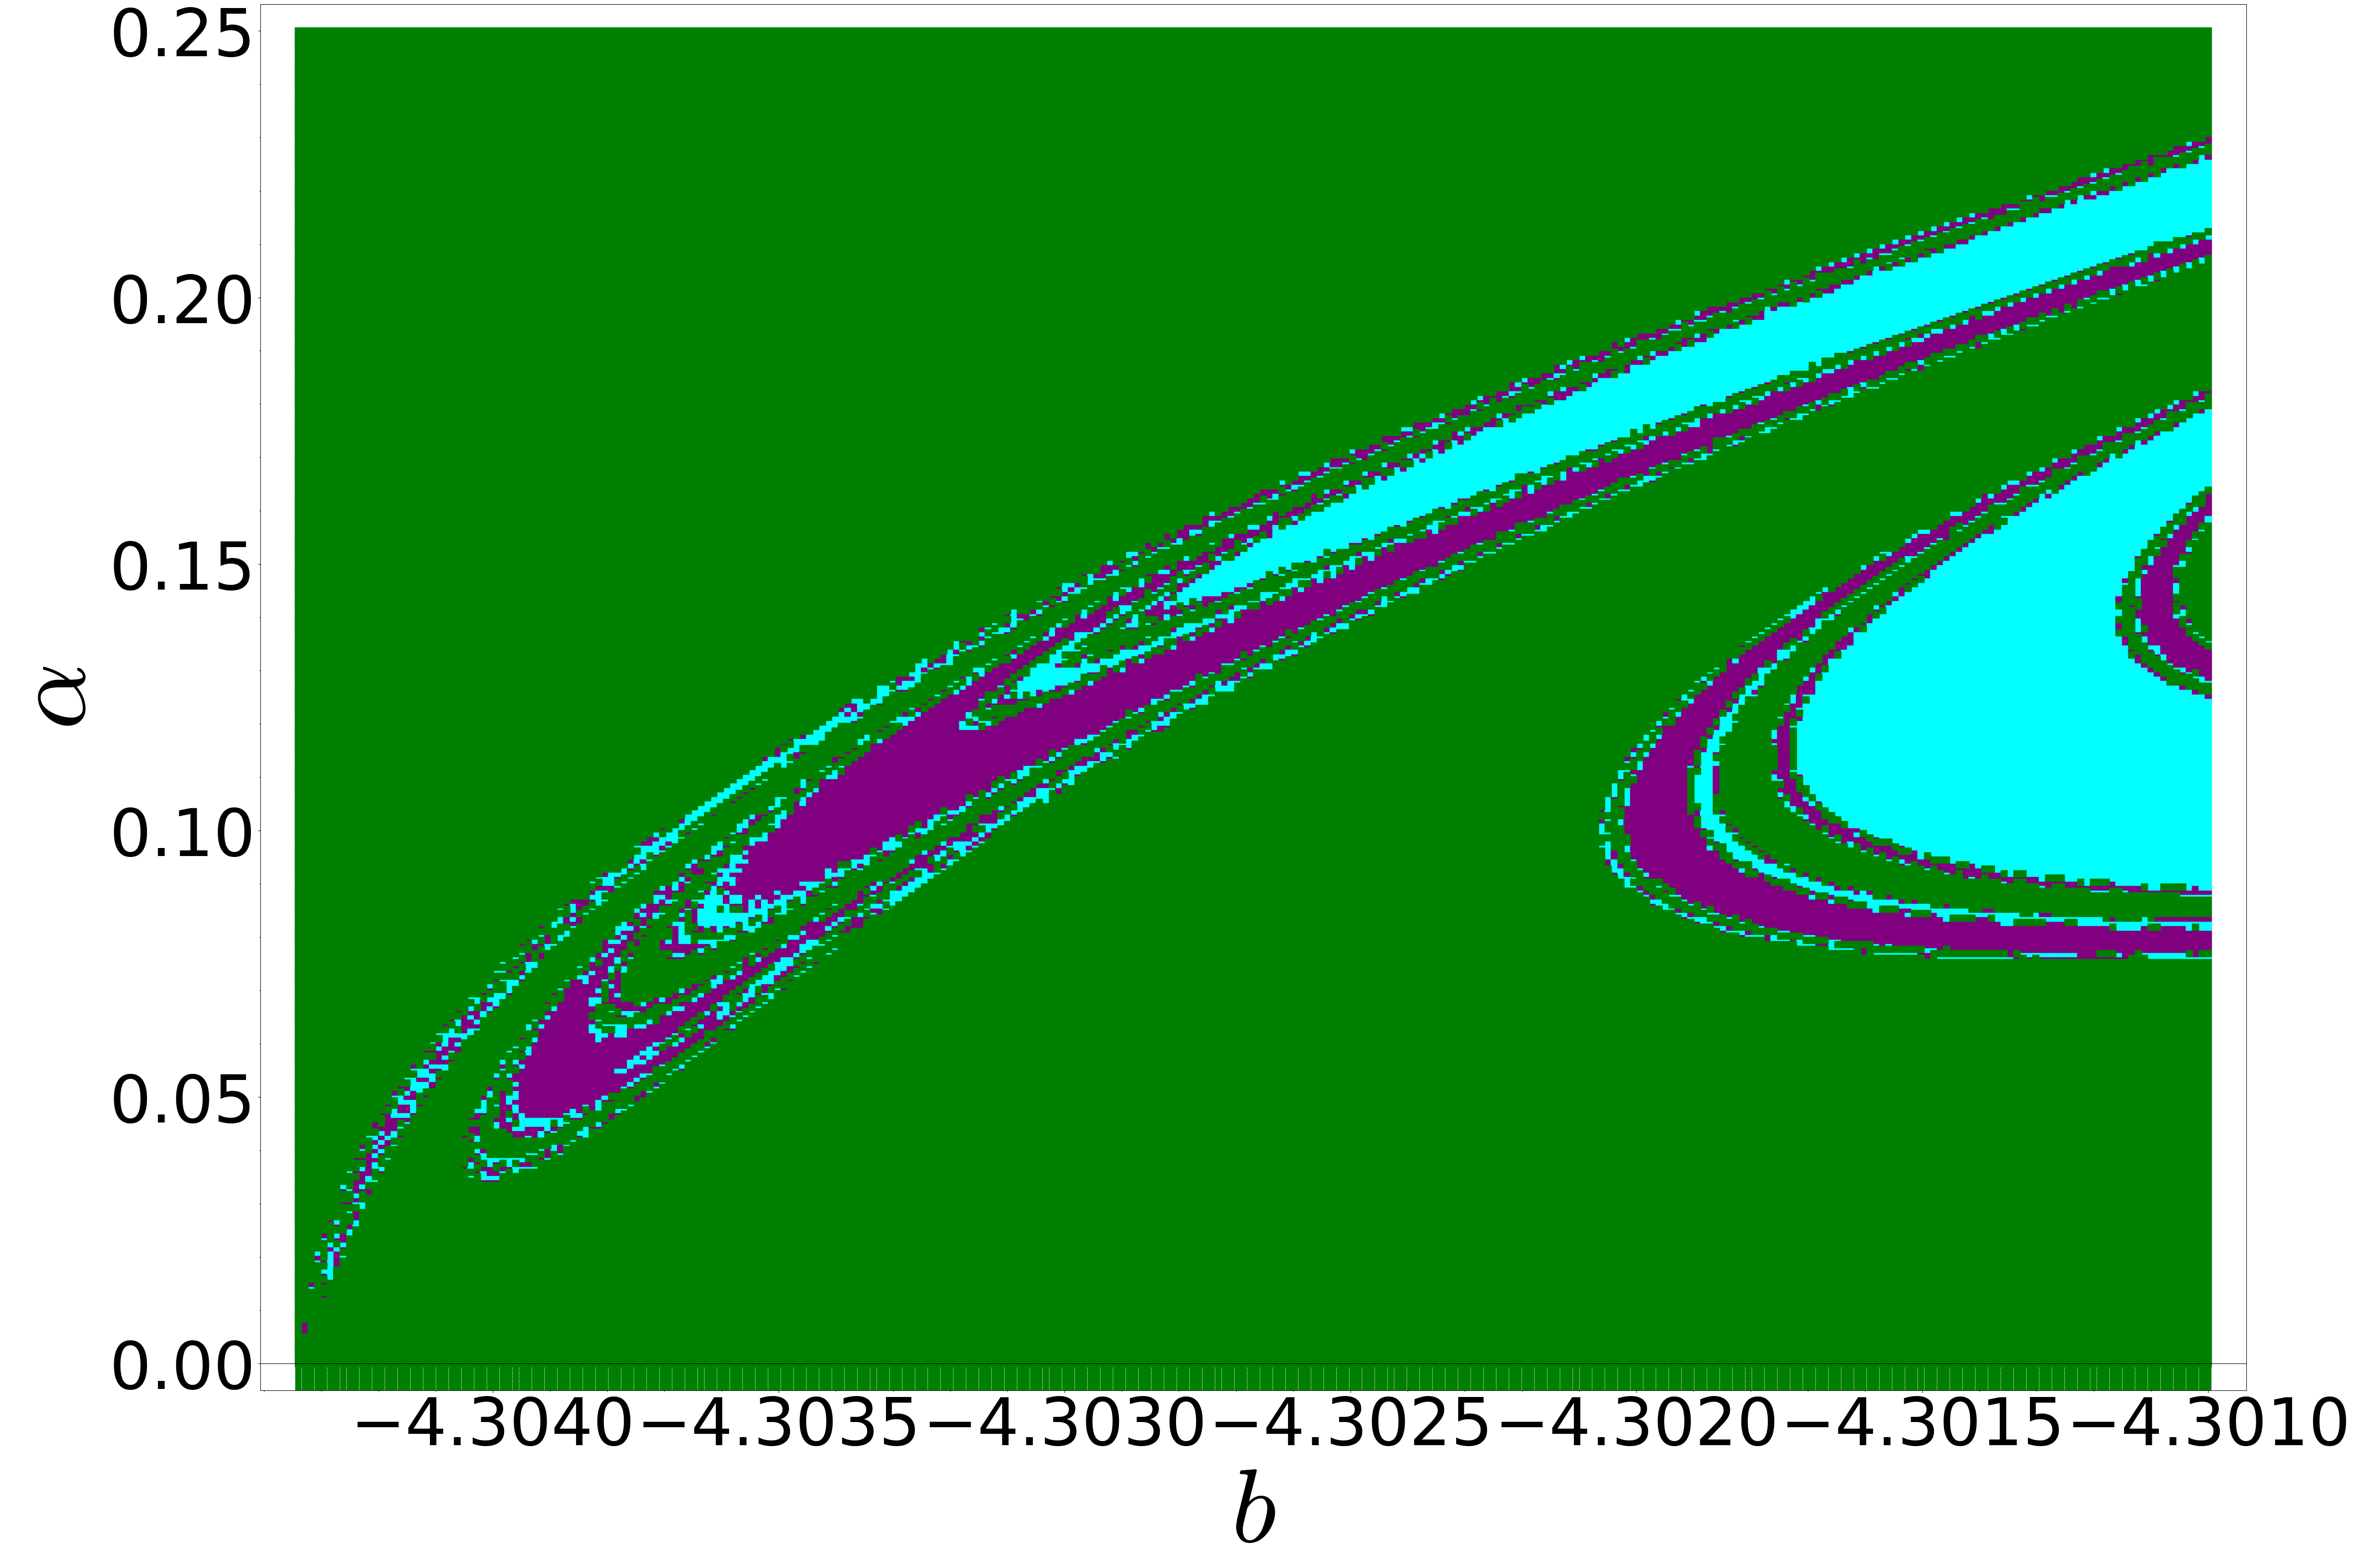

In [15]:
graph1=scatter_plot(shad_points,aspect_ratio='automatic',figsize=[50,50],alpha=1,markersize=100,zorder=1,marker="s",edgecolor=colors,facecolor=colors,frame=True)
graph2=scatter_plot(shadow_symm,aspect_ratio='automatic',figsize=[50,50],alpha=1,markersize=80,zorder=1,marker="s",edgecolor=colors,facecolor=colors,frame=True)  
graph3=scatter_plot(lig_points,aspect_ratio='automatic',figsize=[50,50],alpha=1,markersize=100,zorder=1,marker="s",edgecolor='green',facecolor='green',frame=True)
graph4=scatter_plot(light_symm,aspect_ratio='automatic',figsize=[50,50],alpha=1,markersize=80,zorder=1,marker="s",edgecolor='green',facecolor='green',frame=True)  


graph=graph1+graph2+graph3+graph4
show(graph,xmin=-4.30434,xmax=-4.301,ymin=0,ymax=0.25,fontsize=100,figsize=50,ticks=[0.0005,0.05],axes_labels=[r'$b$', r'$\alpha$'],frame=True) 